# Data Analysis of Misc Dataset

In [42]:
import sys
sys.path.append('../../../src')

import glob, os
import numpy as np 
import scipy as sp
import pandas as pd
from sklearn import decomposition, datasets, svm
from matplotlib import pyplot as plt
from p1.models.utils import get_divided_data, get_data_comp, get_common_label
from p1.models.utils import get_data_col, get_project_data, get_num, get_attr_nums
from p1.models.utils import creat_pred_file, calc_acc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [43]:
# Get Files
data_dir = "../project_data/data"
labels = ["guilty", "not guilty"]

(_, _, _, misc), Y = get_project_data(opts=[False, False, False, True])

## Experiments

In [44]:
misc_train, misc_eval, misc_test = (misc[i] for i in range(3))
Y_train, Y_eval, Y_test = (Y[i] for i in range(3))

### Data Visualization and Analysis

#### Dataset Attributes
**defendant_age**, 
**gender**, 
**num_victims**, 
**victim_genders**, 
**offence_category**, 
**offence_subcategory**

#### Defendent Age Attribute Analysis

Calculation of average suspect ages in training set.

In [45]:
# Calculate average age of suspects in training set. 
# Do not consider unknown ages (eg, 'not known' and 'shop-foreman').
from word2number.w2n import word_to_num
import re

ages = get_data_col(misc_train, "defendant_age")

t_len = len(ages)

known_ages_train = get_attr_nums(misc_train, attr_id="defendant_age", uk="not known")

avg_age = np.mean(known_ages_train[~np.isnan(known_ages_train)])
print(f"Average age of suspects in training set: {int(avg_age)} years old")


Average age of suspects in training set: 29 years old


Common label in training set:

In [46]:
print(f"Common label: {labels[int(get_common_label(Y_train)[0])]}. With occurance: {get_common_label(Y_train)[1]}")

Common label: not guilty. With occurance: 8789


Common labels of subset w/ and w/o unknown suspect ages.

In [47]:
y_k = Y_train[~np.isnan(known_ages_train)]; cl_k = get_common_label(y_k)
y_uk = Y_train[np.isnan(known_ages_train)]; cl_uk = get_common_label(y_uk)

print(f"Common label of subset with known suspect ages: {labels[int(cl_k[0])]}. With occurance: {cl_k[1]} / {len(y_k)}")
print(f"Common label of subset with unknown suspect ages: {labels[int(cl_uk[0])]}. With occurance: {cl_uk[1]} / {len(y_uk)}")

Common label of subset with known suspect ages: guilty. With occurance: 6387 / 7840
Common label of subset with unknown suspect ages: not guilty. With occurance: 7336 / 9660


* Discussion: From the results above on the training set, if a defendent's age is unknown, then they are likely guilty. However, if the suspect's age is known then they are likely not guilty.

Number of adults and children in subset containing known ages.

In [48]:
adult_mask = ~np.isnan(known_ages_train) & (known_ages_train >= 18)
y_a = Y_train[adult_mask]; cl_a = get_common_label(y_a)

ch_mask = ~np.isnan(known_ages_train) & (known_ages_train < 18)
y_c = Y_train[ch_mask]; cl_c = get_common_label(y_c)

print(f"Common label of subset with known adult suspects: {labels[int(cl_a[0])]}. With occurance: {cl_a[1]} / {len(y_a)}")
print(f"Common label of subset with known child suspects: {labels[int(cl_c[0])]}. With occurance: {cl_c[1]} / {len(y_c)}")

Common label of subset with known adult suspects: guilty. With occurance: 5554 / 6923
Common label of subset with known child suspects: guilty. With occurance: 833 / 917


* Discussion: For both identified adult and child defendants, cases rule 'not guilty' in 80% of adult cases and 91% of child cases.

Visualization of known age subset. Points at y = 1.0 imply an adult suspect else a child suspect, where an adult is a person of age $\geq$ 18 years of age.

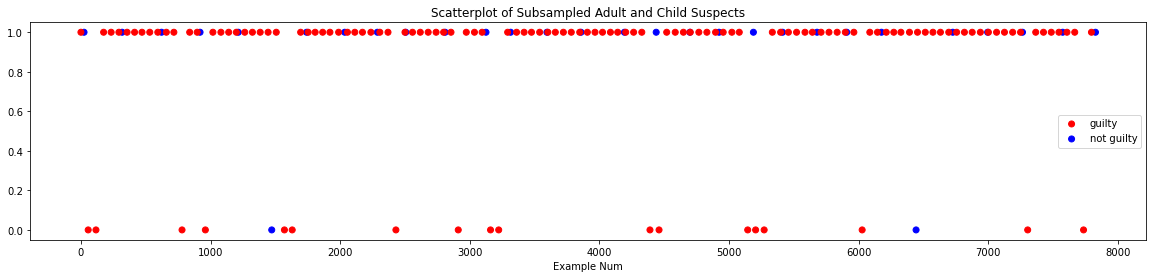

In [49]:
ka_subset = known_ages_train[~np.isnan(known_ages_train)]
colors = np.array(['b' if y_k[i] else 'r' for i in range(len(y_k))])
# colors_uk = ['b' if y_uk[i] else 'r' for i in range(len(y_uk))]

x = np.arange(len(y_k))

fig = plt.figure(figsize=[20, 4])

ng_mask = y_k == 1
ss = 50
ng = plt.scatter(x[ng_mask][::ss], (ka_subset >= 18)[ng_mask][::ss], \
                 color=colors[ng_mask][::ss])
g_mask = y_k == 0
g = plt.scatter(x[g_mask][::ss], (ka_subset >= 18)[g_mask][::ss], \
                 color=colors[g_mask][::ss])
plt.legend((g, ng), labels)
plt.title("Scatterplot of Subsampled Adult and Child Suspects")
plt.xlabel("Example Num")
plt.show()

Visualization of training dataset by the defendant age attribute. 1.0 -> Known age, 0.0 -> Unknown age.

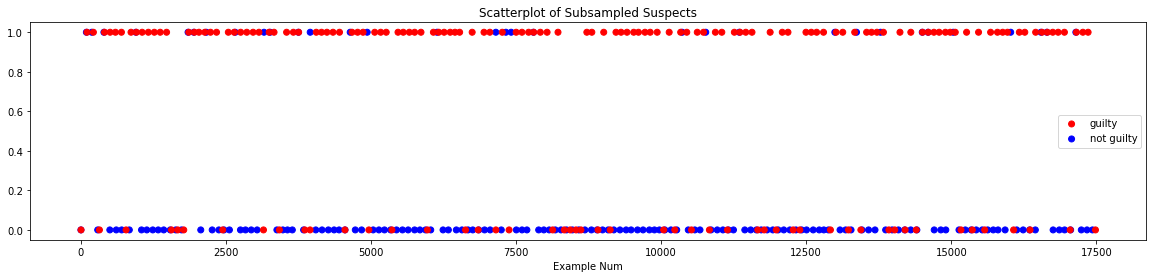

In [50]:
colors = np.array(['b' if y else 'r' for y in Y_train])

x = np.arange(len(Y_train))

fig = plt.figure(figsize=[20, 4])

ss = 50

k_mask = ~np.isnan(known_ages_train)
ng_mask = Y_train == 1
ng = plt.scatter(x[ng_mask][::ss], k_mask[ng_mask][::ss], \
                 color=colors[ng_mask][::ss])

g_mask = Y_train == 0
g = plt.scatter(x[g_mask][::ss], k_mask[g_mask][::ss], \
                 color=colors[g_mask][::ss])

plt.legend((g, ng), labels)
plt.title("Scatterplot of Subsampled Suspects")
plt.xlabel("Example Num")
plt.show()

Consider a simple learner that classifies an example guilty if the age is known and not-guilty if the age is unknown.

In [51]:
from p1.models.simple_learner import SL 

sl = SL()
print(f"Accuracy on training set: {calc_acc(sl.predict(known_ages_train), Y_train)}")

known_ages_test = get_attr_nums(misc_test, attr_id="defendant_age", uk="not known")
print(f"Accuracy on test set: {calc_acc(sl.predict(known_ages_test), Y_test)}")

Accuracy on training set: 0.7841714285714285
Accuracy on test set: 0.7888888888888889


* Discussion: As seen above the simple classifier is better than randomly guessing.

In [53]:
# Generating a Kaggle submission.
known_ages_eval = get_attr_nums(misc_eval, attr_id="defendant_age", uk="not known")
sl_pred = sl.predict(known_ages_eval)

creat_pred_file(sl_pred, filename="final_sl_JL.csv")